### Part 4 Visualizing K-Means with Leaf Dataset

We will apply K-Means on a small dataset of 1240 binary leaf images with different shapes and try to get a feel for the distribution of leaf images using different visualizations that clarify different aspects about how one can interpret K-Means results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import model_selection
from sklearn import decomposition
from sklearn import linear_model
from sklearn import cluster
from sklearn import ensemble
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from skimage.transform import rescale
from scipy import ndimage as ndi

matplotlib.style.use('fivethirtyeight')

### Data loading and preparation phases

The main assumption of this pre-processing stage is that the absolute sizes of the leafs matter, and not just their shape i.e. leafs with different sizes are most definitely different types of leafs. not sure if it's actually important, but just in case

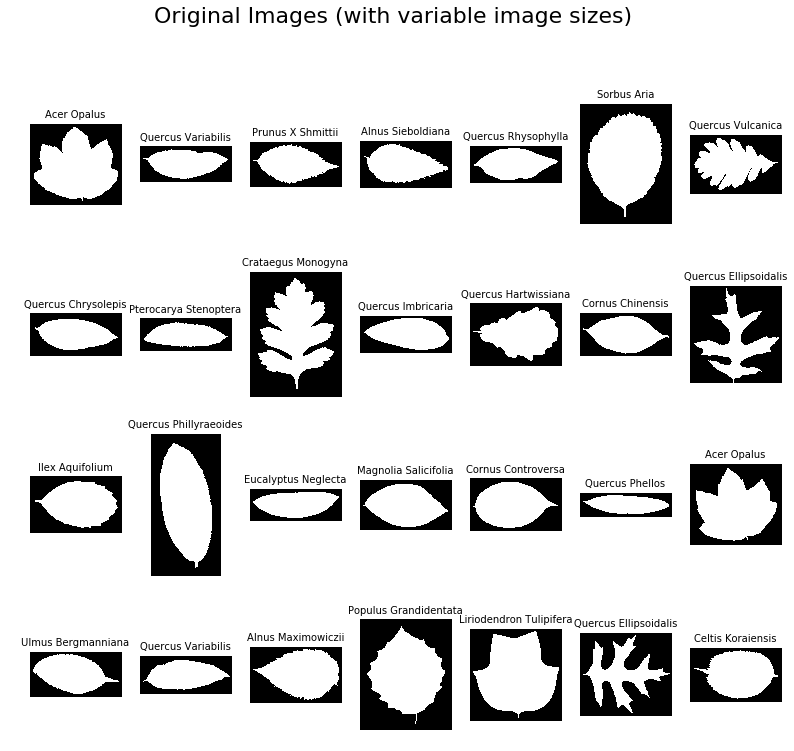

In [2]:
dataDir   = '100 leaves plant species/'
trainData = pd.read_csv('100 leaves plant species/train0.csv', error_bad_lines=False)
classEncoder = LabelEncoder()
trainLabels  = classEncoder.fit_transform(trainData.loc[:,'species'])
trainIDs     = np.array(trainData.loc[:,'id'])

# show some random images
plt.figure(figsize=(12,12))
plt.suptitle('Original Images (with variable image sizes)', fontsize=22)
for k in range(28):
    randTrainInd = np.random.randint(len(trainIDs))
    randomID = trainIDs[randTrainInd]
    imageFilename ='100 leaves plant species/image/' + str(randomID) + '.jpg'
    plt.subplot(4,7,k+1); plt.imshow(mpimg.imread(imageFilename), cmap='gray')
    plt.title(classEncoder.classes_[trainLabels[randTrainInd]], fontsize=10); plt.axis('off')

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


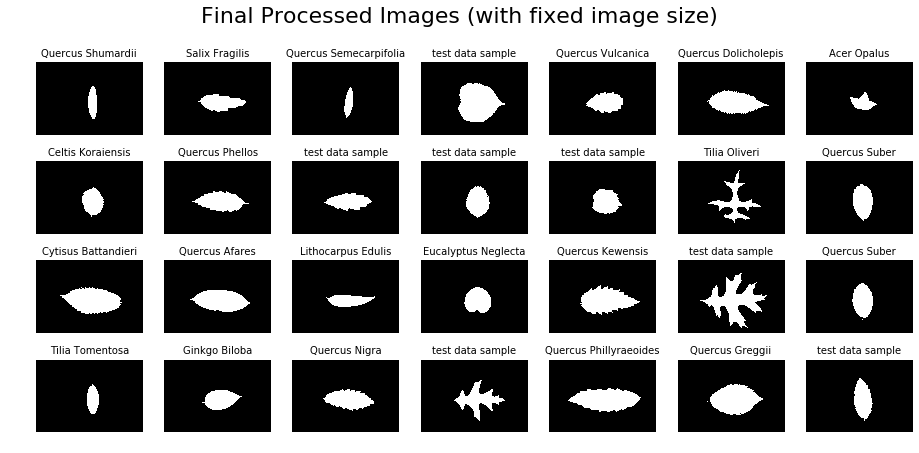

In [3]:
# go over training images and store them in a list
numImages = 1600

shapesMatrix = np.zeros((2,numImages))
listOfImages = []
for k in range(numImages):
    imageFilename = '100 leaves plant species/image/' + str(k+1) + '.jpg'
    currImage = mpimg.imread(imageFilename)
    shapesMatrix[:,k] = np.shape(currImage)
    listOfImages.append(currImage)
    
# calculate the shape of an image that will contain all original images within it
maxShapeSize = shapesMatrix.max(axis=1)
for k in range(len(maxShapeSize)):
    if maxShapeSize[k] % 2 == 0:
        maxShapeSize[k] += 311
    else:
        maxShapeSize[k] += 310
    
    
# place all original images at the center of the large reference frame
fullImageMatrix3D = np.zeros(np.hstack((maxShapeSize, np.shape(shapesMatrix[1]))).astype(int),dtype=np.dtype('u1'))
destXc = (maxShapeSize[1]+1)/2; destYc = (maxShapeSize[0]+1)/2
for k, currImage in enumerate(listOfImages):
    Yc, Xc = ndi.center_of_mass(currImage)
    Xd = destXc - Xc; Yd = destYc - Yc
    rowIndLims = (int(round(Yd)),int(round(Yd)+np.shape(currImage)[0]))
    colIndLims = (int(round(Xd)),int(round(Xd)+np.shape(currImage)[1]))
    fullImageMatrix3D[rowIndLims[0]:rowIndLims[1],colIndLims[0]:colIndLims[1],k] = currImage

'''
# make sure nothing was ruined in the process
plt.figure(figsize=(14,7))
plt.suptitle('Processed Images (fixed size)', fontsize=22)
for k in range(28):
    randInd = np.random.randint(np.shape(fullImageMatrix3D)[2])
    plt.subplot(4,7,k+1); plt.imshow(fullImageMatrix3D[:,:,randInd], cmap='gray'); plt.axis('off')
'''

# re crop according to rows and columns that don't have zeros in them in any image
xValid = fullImageMatrix3D.mean(axis=2).sum(axis=0) > 0
yValid = fullImageMatrix3D.mean(axis=2).sum(axis=1) > 0
xLims = (np.nonzero(xValid)[0][0],np.nonzero(xValid)[0][-1])
yLims = (np.nonzero(yValid)[0][0],np.nonzero(yValid)[0][-1])
fullImageMatrix3D = fullImageMatrix3D[yLims[0]:yLims[1],xLims[0]:xLims[1],:]

# make sure nothing was ruined in the process
plt.figure(figsize=(14,7))
plt.suptitle('Final Processed Images (with fixed image size)', fontsize=22)
for k in range(28):
    randInd = np.random.randint(np.shape(fullImageMatrix3D)[2])
    plt.subplot(4,7,k+1); plt.imshow(fullImageMatrix3D[:,:,randInd], cmap='gray'); plt.axis('off')
    if randInd < len(trainLabels):
        plt.title(classEncoder.classes_[trainLabels[randInd]], fontsize=10)
    else:
        plt.title('test data sample', fontsize=10)
        
# scale down all images to be in normal size
rescaleFactor = 0.15

scaledDownImage = rescale(fullImageMatrix3D[:,:,0],rescaleFactor)
scaledDownImages = np.zeros(np.hstack((np.shape(scaledDownImage),
                                       np.shape(fullImageMatrix3D)[2])),dtype=np.dtype('f4'))
for imInd in range(np.shape(fullImageMatrix3D)[2]):
    scaledDownImages[:,:,imInd] = rescale(fullImageMatrix3D[:,:,imInd],rescaleFactor)
    
del fullImageMatrix3D

### Define a K-means Model class that will help us visualize things

In [4]:
class KmeansModel:

    def __init__(self, X, numClusters=10, objectPixels=None):
        '''
        inputs: 
            X                       - numSamples x numDimentions matrix
            numClusters             - number of clusters to use
            objectPixels (optional) - an binnary mask image used for presentation
                                      will be used as Im[objectPixels] = dataSample
                                      must satisfy objectPixels.ravel().sum() = X.shape[1]
        '''
        numDataSamples = X.shape[0]
        self.numClusters = numClusters        
        if objectPixels is None:
            self.objectPixels = np.ones((1,X.shape[1]),dtype=np.bool)
        else:
            self.objectPixels = objectPixels
        assert(self.objectPixels.ravel().sum() == X.shape[1])

        KmeansModel = cluster.KMeans(n_clusters=numClusters, n_init=5)
        self.dataRepresentation = KmeansModel.fit_transform(X)
        self.KmeansModel = KmeansModel
        
        # calculate cluster frequency
        clusterInds = KmeansModel.labels_
        clusterFrequency = []
        for clusterInd in range(numClusters):
            clusterFrequency.append((clusterInds == clusterInd).sum()/float(numDataSamples))
        self.clusterFrequency = np.array(clusterFrequency)
        self.sortedTemplatesByFrequency = np.flipud(np.argsort(clusterFrequency))

    def RepresentUsingModel(self, X, representationMethod='distFromAllClusters'):
        
        if representationMethod == 'distFromAllClusters':
            return self.KmeansModel.transform(X)
        if representationMethod == 'clusterIndex':
            return self.KmeansModel.predict(X)
        if representationMethod == 'oneHotClusterIndex':
            clusterAssignment = self.KmeansModel.predict(X)
            X_transformed = np.zeros((X.shape[0],self.numClusters))
            for sample in range(X.shape[0]):
                X_transformed[sample,clusterAssignment[sample]] = 1
            return X_transformed

    def ReconstructUsingModel(self, X_transformed, representationMethod='distFromAllClusters'):

        if representationMethod == 'clusterIndex':
            clusterAssignment = X_transformed
        if representationMethod == 'oneHotClusterIndex':
            clusterAssignment = np.argmax(X_transformed,axis=1)
        if representationMethod == 'distFromAllClusters':
            clusterAssignment = np.argmin(X_transformed,axis=1)

        X_reconstructed = np.zeros((X_transformed.shape[0],self.KmeansModel.cluster_centers_.shape[1]))
        for sample in range(X_transformed.shape[0]):
            X_reconstructed[sample,:] = self.KmeansModel.cluster_centers_[clusterAssignment[sample],:]
                
        return X_reconstructed
        
    def InterpretUsingModel(self, X, representationMethod='clusterIndex'):
        return self.ReconstructUsingModel(\
                        self.RepresentUsingModel(X,representationMethod),representationMethod)

    # shows the cluster centers
    def ShowTemplates(self, numTemplatesToShow=16):
        numTemplatesToShow = min(numTemplatesToShow, self.numClusters)
        
        numFigRows = np.ceil(np.sqrt(numTemplatesToShow)); 
        numFigCols = np.ceil(np.sqrt(numTemplatesToShow));
        numTemplatesPerFigure = int(numFigRows*numFigCols)
        numFigures = int(np.ceil(float(numTemplatesToShow)/numTemplatesPerFigure))
                
        for figureInd in range(numFigures):
            plt.figure()
            for plotInd in range(numTemplatesPerFigure):
                templateInd = self.sortedTemplatesByFrequency[numTemplatesPerFigure*figureInd + plotInd]
                if templateInd >= self.numClusters:
                    break
                templateImage = np.zeros(np.shape(self.objectPixels))
                templateImage[self.objectPixels] = \
                        self.KmeansModel.cluster_centers_[templateInd,:].ravel()

                plt.subplot(numFigRows,numFigCols,plotInd+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(templateImage)
                else:
                    plt.imshow(templateImage,cmap='hot'); plt.axis('off')
                plt.title(str(100*self.clusterFrequency[templateInd])[:4] + '% frequency');
            plt.tight_layout()
            
    # shows several random model reconstructions
    def ShowReconstructions(self, X, numReconstructions=6):
        assert(np.shape(X)[1] == self.objectPixels.ravel().sum())
        numSamples = np.shape(X)[0]
        numReconstructions = min(numReconstructions, numSamples)
        
        originalImage      = np.zeros(np.shape(self.objectPixels))
        reconstructedImage = np.zeros(np.shape(self.objectPixels))
        
        numReconstructionsPerFigure = min(6, numReconstructions)
        numFigures = int(np.ceil(float(numReconstructions)/numReconstructionsPerFigure))
        
        for figureInd in range(numFigures):
            plt.figure()
            for plotCol in range(numReconstructionsPerFigure):
                dataSampleInd = np.random.randint(numSamples)
                originalImage[self.objectPixels] = X[dataSampleInd,:].ravel()
                reconstructedImage[self.objectPixels] = \
                        self.InterpretUsingModel(np.reshape(X[dataSampleInd,:],[1,-1])).ravel()
                diffImage = abs(originalImage - reconstructedImage)
                
                # original image
                plt.subplot(3,numReconstructionsPerFigure,0*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(originalImage); plt.title('original signal')
                else:
                    plt.imshow(originalImage, cmap='gray'); 
                    plt.title('original image'); plt.axis('off')
                    
                # reconstred image
                plt.subplot(3,numReconstructionsPerFigure,1*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(reconstructedImage); plt.title('reconstructed signal')
                else:
                    plt.imshow(reconstructedImage, cmap='gray'); 
                    plt.title('reconstructed image'); plt.axis('off')

                # diff image
                plt.subplot(3,numReconstructionsPerFigure,2*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(diffImage); plt.title('abs difference signal')
                else:
                    plt.imshow(diffImage, cmap='gray'); 
                    plt.title('abs difference image'); plt.axis('off')
            plt.tight_layout()


    # shows distrbution along the distance from a particular cluster and several examples for that distance
    def ShowSingleTemplateDistances(self, X, listOfTemplates=[0,1]):

        showAsTraces = (np.shape(self.objectPixels)[0] == 1)
        assert(all([(x in range(self.numClusters)) for x in listOfTemplates]))
                
        X_rep = self.RepresentUsingModel(X, representationMethod='distFromAllClusters')
        
        percentilesToShow = [1,5,10,30,60,99]
        numReadDataSamplePerPercentile = 4
        representationPercentiles = []
        for percentile in percentilesToShow:
            representationPercentiles.append(np.percentile(self.dataRepresentation, percentile, axis=0))
        medianRepVec =  np.percentile(self.dataRepresentation, 50, axis=0)

        for templateInd in listOfTemplates:
            plt.figure(); gs = gridspec.GridSpec(numReadDataSamplePerPercentile+2,
                                                 len(percentilesToShow))

            # calculate the Gaussian smoothed distribution of values along the eignevector direction
            sigmaOfKDE = (representationPercentiles[-1][templateInd] - 
                          representationPercentiles[1][templateInd])/100.0
            pdfStart   = representationPercentiles[1][templateInd]  - 15*sigmaOfKDE
            pdfStop    = representationPercentiles[-1][templateInd] + 15*sigmaOfKDE
            xAxis = np.linspace(pdfStart,pdfStop,200)
            PDF_Model = KernelDensity(kernel='gaussian', \
                            bandwidth=sigmaOfKDE).fit(self.dataRepresentation[:,templateInd].reshape(-1,1))
            logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))
            percentileValuesToShow = \
                [representationPercentiles[x][templateInd] for x in range(len(representationPercentiles))]
            percentilesToShowLogPDF = \
                PDF_Model.score_samples(np.array(percentileValuesToShow).reshape(-1,1))

            # show distribution of distance from current template and red dots at the list of precentiles to show 
            plt.subplot(gs[0,:])
            plt.fill(xAxis, np.exp(logPDF), fc='b', alpha=0.9);
            plt.scatter(percentileValuesToShow, np.exp(percentilesToShowLogPDF), c='r',s=40);
            plt.title(str(100*self.clusterFrequency[templateInd])[:4] + '% assignment frequency');

            for plotCol, currPrecentile in enumerate(percentilesToShow):                
                currPrecentileRepVec              = medianRepVec.copy()
                currPrecentileRepVec[templateInd] = representationPercentiles[plotCol][templateInd]
                
                currPrecentileImage = np.zeros(np.shape(self.objectPixels))
                currPrecentileRepVec = currPrecentileRepVec[:,np.newaxis].T
                currPrecentileImage[self.objectPixels] = \
                            self.ReconstructUsingModel(currPrecentileRepVec).ravel()
                
                # show the median image with current precentile as activation of the curr image
                plt.subplot(gs[1,plotCol]);
                if showAsTraces:
                    plt.plot(currPrecentileImage); 
                    plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%')
                else:
                    plt.imshow(currPrecentileImage, cmap='hot'); 
                    plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); plt.axis('off')

                # find the most suitible candidates in X for current precentile
                distFromPercentile = abs(X_rep[:,templateInd] - 
                                         representationPercentiles[plotCol][templateInd])
                X_inds = np.argpartition(distFromPercentile, \
                                         numReadDataSamplePerPercentile)[:numReadDataSamplePerPercentile]
                for k, X_ind in enumerate(X_inds):
                    currNearestPrecentileImage = np.zeros(np.shape(self.objectPixels))
                    currNearestPrecentileImage[self.objectPixels]  = X[X_ind,:].ravel()
                    
                    plt.subplot(gs[2+k,plotCol]);
                    if showAsTraces:
                        plt.plot(currNearestPrecentileImage); 
                        plt.title('NN with closest percentile');
                    else:
                        plt.imshow(currNearestPrecentileImage, cmap='gray'); 
                        plt.title('NN with closest percentile'); plt.axis('off')
            plt.tight_layout()
            
            
    def ShowDataScatterPlotsWithTSNE(self, X=None, y=None, tSNE_perplexity=30.0, colorMap='Paired'):
        # show the distance from 2 most frequent clusters and the tSNE of the entire "distance form template" space 
        
        if X is None:
            X_rep = self.dataRepresentation
        else:
            X_rep = self.RepresentUsingModel(X)
            
        if y is None:
            y = np.ones(X_rep.shape[0])
            
        tSNE_KmeansModel = TSNE(n_components=2, perplexity=tSNE_perplexity, random_state=0)
        X_rep_tSNE = tSNE_KmeansModel.fit_transform(X_rep)
        
        # take the two most frequent patterns
        mostFrequent = self.sortedTemplatesByFrequency[:2]
        
        plt.figure()
        plt.subplot(1,2,1); 
        plt.scatter(X_rep[:,mostFrequent[0]], \
                    X_rep[:,mostFrequent[1]],c=y,cmap=colorMap,s=10,alpha=0.9)
        plt.title('"distance form template" representation'); 
        plt.xlabel('distance from template 1'); plt.ylabel('distance from template 2')
        plt.subplot(1,2,2); 
        plt.scatter(X_rep_tSNE[:,0],X_rep_tSNE[:,1],c=y,cmap=colorMap,s=15,alpha=0.9)
        plt.title('t-SNE of Kmeans representation'); plt.xlabel('t-SNE axis1'); plt.ylabel('t-SNE axis2')


    def ShowTemplatesInPCASpace(self, X, y=None, tSNE_perplexity=30.0, colorMap='Paired'):
        # show the templates in the 2PC space and the tSNE of the entire PCA space
        
        # build PCA model and project the data onto the PCA space
        PCAModel = decomposition.PCA(n_components=60, whiten=False)
        X_rep = PCAModel.fit_transform(X)
                
        # project the Kmeans templates onto the PCA space
        templates_rep = PCAModel.transform(templateModel.KmeansModel.cluster_centers_)
        
        if y is None:
            y = self.RepresentUsingModel(X, representationMethod='clusterIndex')
            
        tSNE_PCAModel = TSNE(n_components=2, perplexity=tSNE_perplexity, random_state=0)
        X_rep_tSNE = tSNE_PCAModel.fit_transform(np.vstack((X_rep,templates_rep))) 
        
        plt.figure()
        plt.subplot(1,2,1); plt.scatter(X_rep[:,0],X_rep[:,1],c=y,cmap=colorMap,s=15,alpha=0.9)
        plt.scatter(templates_rep[:,0],templates_rep[:,1],c='k',cmap=colorMap,s=50)
        plt.title('PCA representation'); plt.xlabel('PC1 coeff'); plt.ylabel('PC2 coeff')
        
        nC = templates_rep.shape[0]        
        plt.subplot(1,2,2); 
        plt.scatter(X_rep_tSNE[:-nC,0],\
                    X_rep_tSNE[:-nC,1],c=y,cmap=colorMap,s=15,alpha=0.9)
        plt.scatter(X_rep_tSNE[-nC:,0],\
                    X_rep_tSNE[-nC:,1],c='k',cmap=colorMap,s=50)
        plt.title('t-SNE of PCA representation'); plt.xlabel('t-SNE axis1'); plt.ylabel('t-SNE axis2')

## Now lets apply k-means and look at the cluster centers

We'll think of each image as a point in a high dimensional space, and each cluster center is a different point in the high dimensional image space.

### k=4

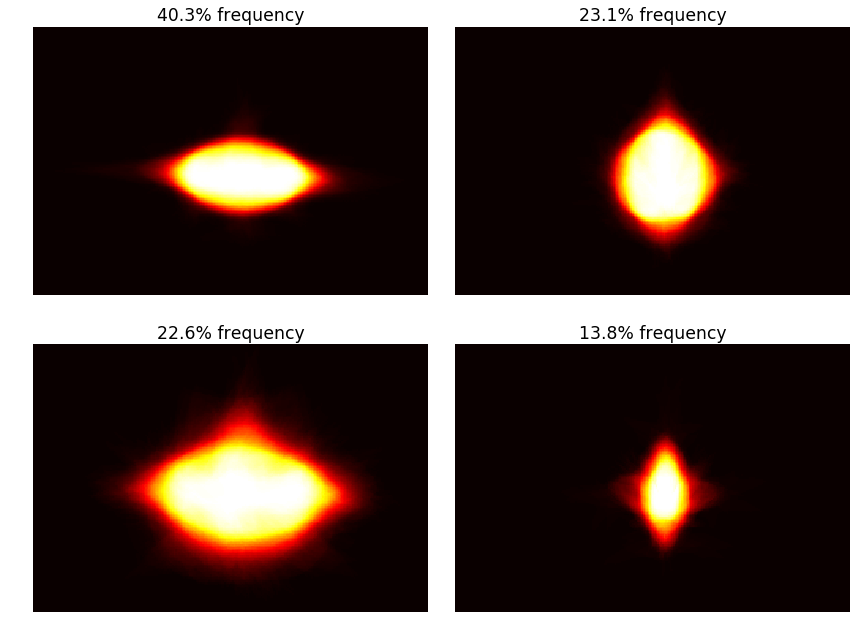

In [5]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,9)

objectPixels = np.ones((np.shape(scaledDownImages)[0],np.shape(scaledDownImages)[1])) == 1
sampleDim = np.shape(scaledDownImages)[0]*np.shape(scaledDownImages)[1]
X = scaledDownImages.reshape(sampleDim,-1).T

templateModel = KmeansModel(X, numClusters=4, objectPixels=objectPixels)
templateModel.ShowTemplates(numTemplatesToShow=4)

We can see that the centers are basically just large or small leaves, elongated either vertically and horizontally

### k=9

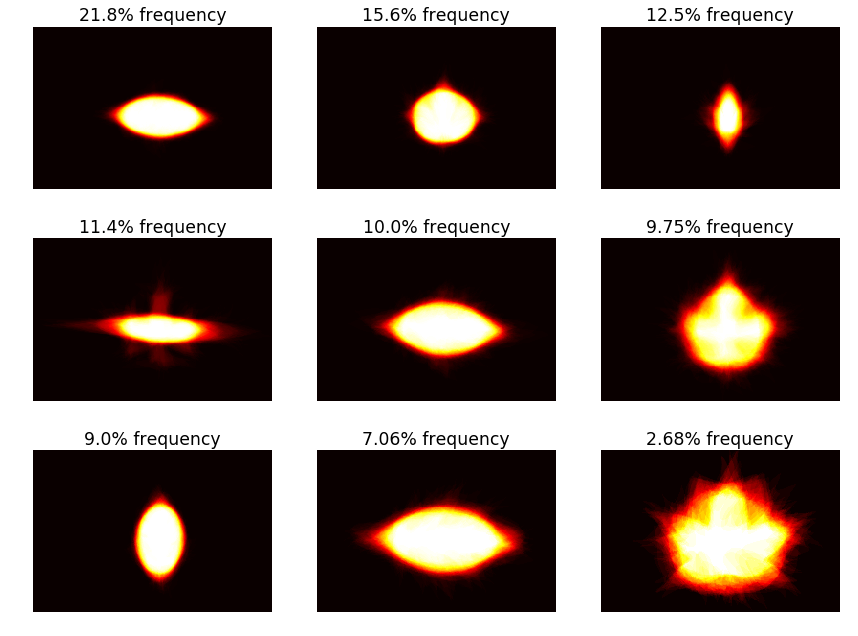

In [6]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,9)

templateModel = KmeansModel(X, numClusters=9, objectPixels=objectPixels)
templateModel.ShowTemplates(numTemplatesToShow=9)

we start seeing some more specificity in the cluster centers

### k=16

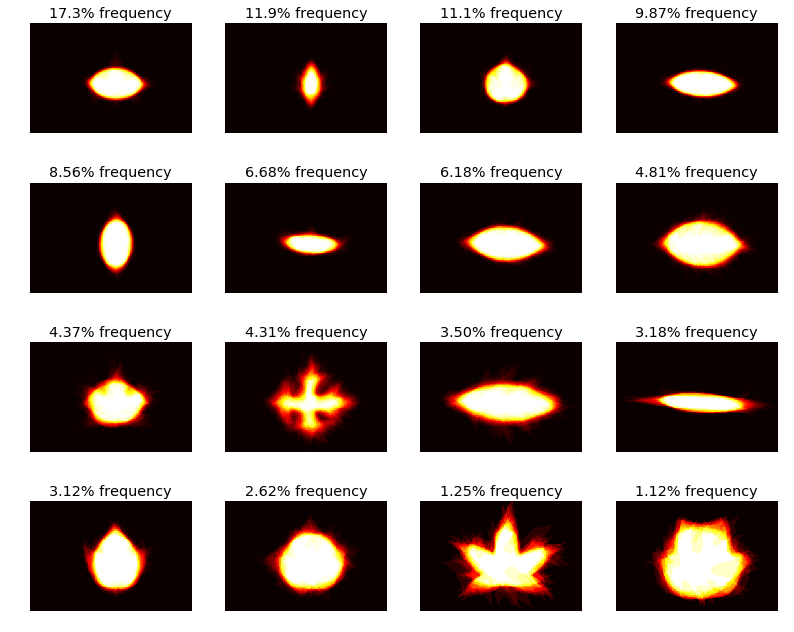

In [7]:
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (11,9)

templateModel = KmeansModel(X, numClusters=16, objectPixels=objectPixels)
templateModel.ShowTemplates(numTemplatesToShow=16)

we can clearly see templates here that are very much leaf type specific

### k=36

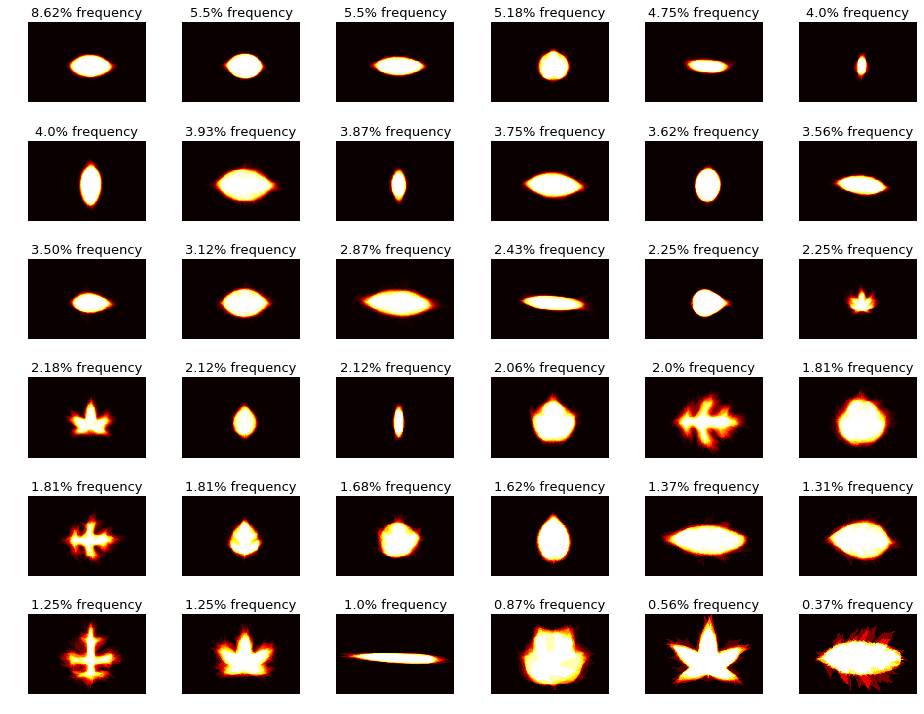

In [8]:
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (13,10)

templateModel = KmeansModel(X, numClusters=36, objectPixels=objectPixels)
templateModel.ShowTemplates(numTemplatesToShow=36)

We can see even more clearly templates that are leaf type specific. this gives us hope regarding the possibility of using these features later for classification purposes.

## Model Reconstructions:

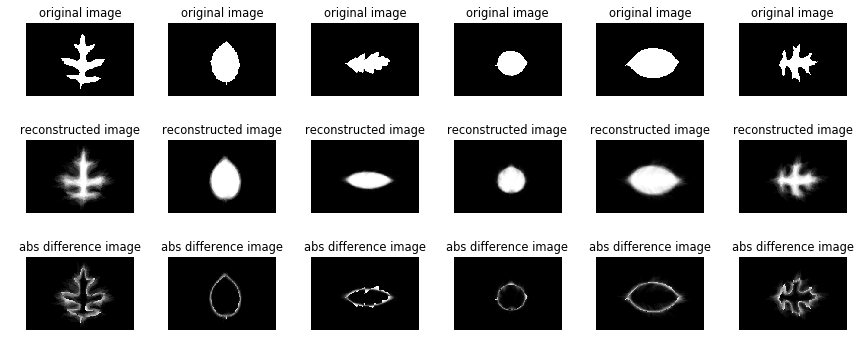

In [9]:
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.figsize'] = (12,5)

templateModel.ShowReconstructions(X, numReconstructions=6)

We can see that the reconstructions are OK but far from perfect

## Now let's visualize how these cluster center look like in the original high dimensional space

For this purpose we first apply PCA to reduce dimensionality of the images and then show the data once in the space of the first two principal components and in the full PCA space as visualized by t-SNE.

The cluster centers are in black, and the data points are colored according to cluster assignment

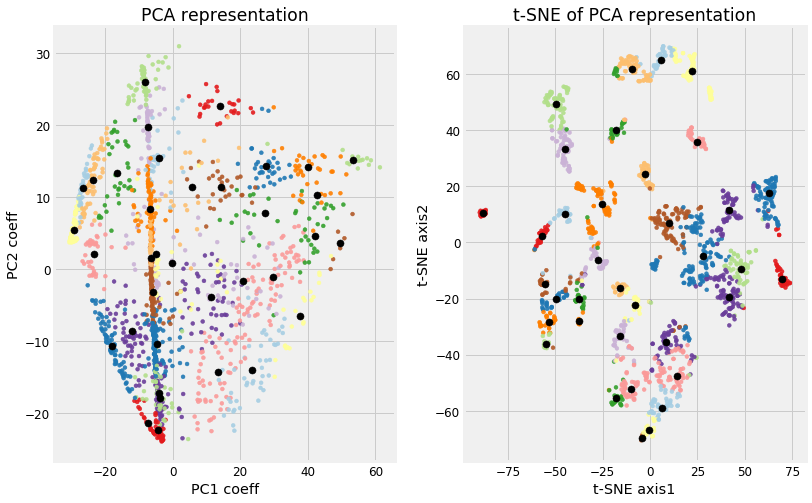

In [10]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

templateModel.ShowTemplatesInPCASpace(X, y=None, tSNE_perplexity=15.0, colorMap='Paired')

## Show the distribution of distances of data samples from the most frequent template

This will help us get a feel for what what different distances represent by plotting several examples that are distant from that template by approximately that amount

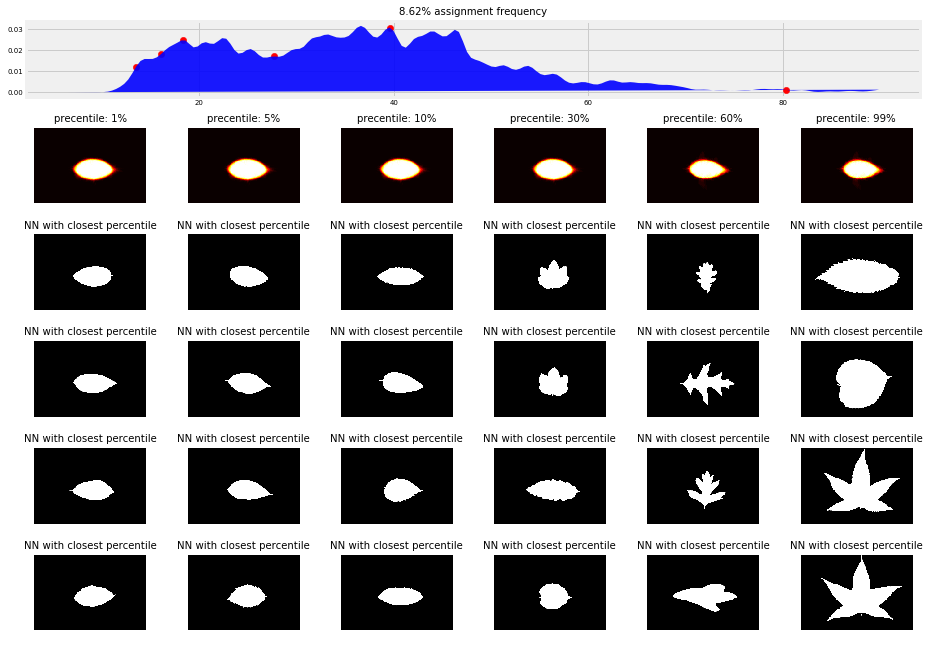

In [11]:
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (13,9)

mostFrequentClusterInd = templateModel.sortedTemplatesByFrequency[0]
templateModel.ShowSingleTemplateDistances(X, listOfTemplates=[mostFrequentClusterInd])

From here we can see that all similar patterns (more to the left) are similar in the same way, and that all dissimilar patterns (more to the right) are different in their own unique way. Well, even though it's a very good quote, it isn't actually what we see in this dataset.

What we do see is something a little bit surprising, if we think about it from the geometric point of view. points (leaf images) that are far away from a specific point (a template) can theoretically be far away in many different directions and therefore one would expect large diversity among all images that are at the same distance from a specific template. This is only a little bit the case. We can also see some similarities between equally distant points relative to a template. What this means is that this feature "distance from template i" can be informative beyond just a binary type "like template i" vs "not like template i" feature.

## Let's look at another such feature (distance from 10th most frequent template):

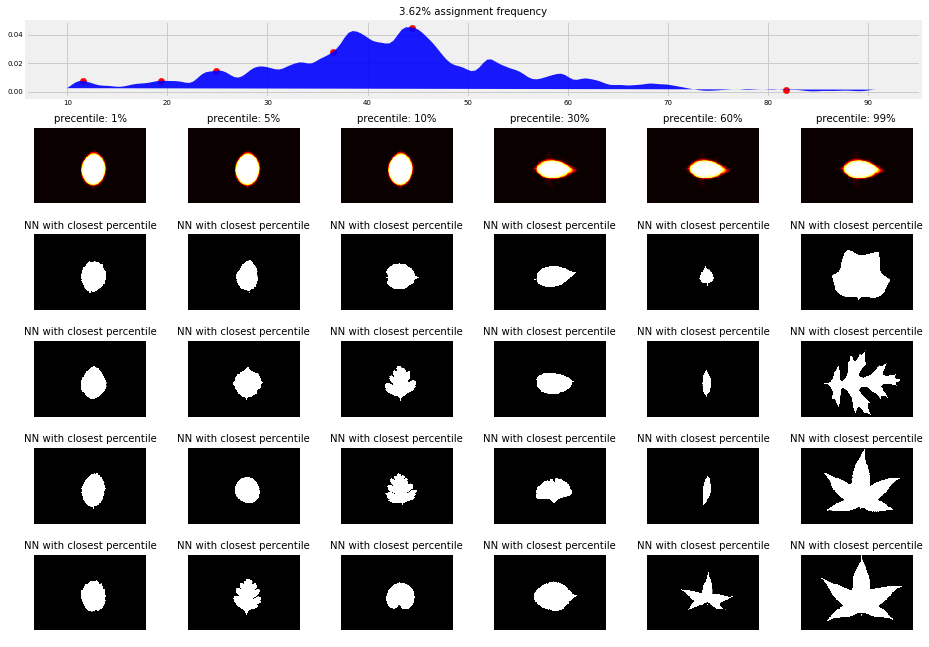

In [12]:
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (13,9)

mediumFrequencyClusterInd = templateModel.sortedTemplatesByFrequency[10]
templateModel.ShowSingleTemplateDistances(X, listOfTemplates=[mediumFrequencyClusterInd])

Again, we see similar things happen in this feature as well.

## Visualize "distance from cluster centers" feature space

Plot the scatter of distance from the two most frequent clusters, and the low dimensional t-SNE representation of the entire "distance from clusters" space. the colors indicate the leaf type.

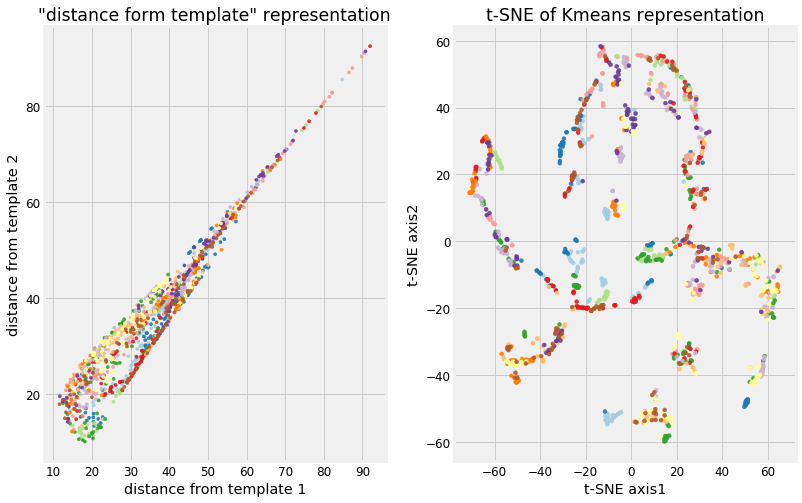

In [13]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

X_train = X[trainIDs-1,:]
y_train = trainLabels

templateModel.ShowDataScatterPlotsWithTSNE(X=X_train, y=y_train, tSNE_perplexity=15.0, colorMap='Paired')

## Show Model Accuracy as function of number of clusters used

Now, similar to what we did for PCA, let's try to see what is the classification accuracy using k-means features for several different values of K and several differnt classifiers

Text(0.5,1,'accuracy as function of num Clusters')

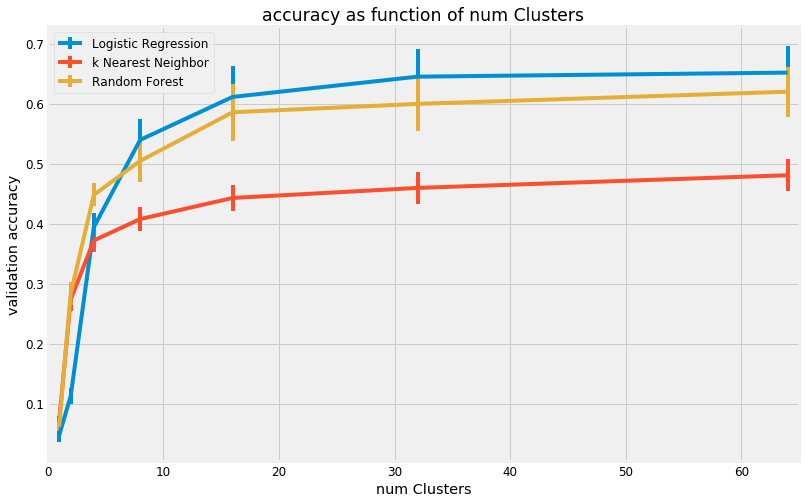

In [14]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

numClustersToUse = [1,2,4,8,16,32,64]

logReg = linear_model.LogisticRegression(C=10.0)
kNN = neighbors.KNeighborsClassifier(n_neighbors=7)
RF = ensemble.RandomForestClassifier(n_estimators=100)

logRegMeanAccuracy = []; kNN_MeanAccuracy = []; RF_MeanAccuracy = []
logRegAccuracyStd  = []; kNN_AccuracyStd  = []; RF_AccuracyStd  = []

for k in numClustersToUse:
    stratifiedCV = model_selection.StratifiedKFold(n_splits=5, random_state=1)
    logRegAccuracy = []; kNN_Accuracy = []; RF_Accuracy = []
    
    templateModel = KmeansModel(X_train, numClusters=k)
    X_kmeans_train = templateModel.RepresentUsingModel(X_train, representationMethod='distFromAllClusters')
    
    for trainInds, validInds in stratifiedCV.split(X_kmeans_train, y_train):
        X_train_cv = X_kmeans_train[trainInds,:]
        X_valid_cv = X_kmeans_train[validInds,:]

        y_train_cv = y_train[trainInds]
        y_valid_cv = y_train[validInds]

        logReg.fit(X_train_cv, y_train_cv)
        kNN.fit(X_train_cv, y_train_cv)
        RF.fit(X_train_cv, y_train_cv)
    
        logRegAccuracy.append(accuracy_score(y_valid_cv, logReg.predict(X_valid_cv)))
        kNN_Accuracy.append(accuracy_score(y_valid_cv, kNN.predict(X_valid_cv)))
        RF_Accuracy.append(accuracy_score(y_valid_cv, RF.predict(X_valid_cv)))

    logRegMeanAccuracy.append(np.array(logRegAccuracy).mean())
    logRegAccuracyStd.append(np.array(logRegAccuracy).std())

    kNN_MeanAccuracy.append(np.array(kNN_Accuracy).mean())
    kNN_AccuracyStd.append(np.array(kNN_Accuracy).std())

    RF_MeanAccuracy.append(np.array(RF_Accuracy).mean()) 
    RF_AccuracyStd.append(np.array(RF_Accuracy).std())
        
plt.figure()
plt.errorbar(x=numClustersToUse, y=logRegMeanAccuracy, yerr=logRegAccuracyStd)
plt.errorbar(x=numClustersToUse, y=kNN_MeanAccuracy  , yerr=kNN_AccuracyStd)
plt.errorbar(x=numClustersToUse, y=RF_MeanAccuracy   , yerr=RF_AccuracyStd)
plt.xlim(min(numClustersToUse)-1,max(numClustersToUse)+1); plt.legend(['Logistic Regression','k Nearest Neighbor','Random Forest'],loc=2)
plt.xlabel('num Clusters'); plt.ylabel('validation accuracy'); plt.title('accuracy as function of num Clusters')

we build the k-means mode to show that when there is a center on the dataset. When the distance from the template is further, the difference between the eigenvalues are larger. For example, when there are two points respectively stay in the left and right side with the same distance, the eigenvalues are quietly different. And then we set 2 points which are next to each other, and then we can get the cluster and recognize the species. 

    rederence: KNN:https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

           k-means script: https://mubaris.com/2017/10/01/kmeans-clustering-in-python/

           k-means exmaple: https://www.kaggle.com/naivecharles/k-means-neighborhood-clustering

           k-means model: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

             https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
             
           T-SNE: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

           PCA example: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 

 Copyright <2018> <Weiyi Lan YiQun Xu Yang Zong>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.